In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [7]:
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)

# Use the Inspector to explore the database and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
# inspect columns of measurement table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# inspect columns of station table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(query_date)
# last date in the database is 2017-08-23, so data that goes back 12 months would be 2016-08-23

# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
last_12_months = session.query(Measurement.date, Measurement.prcp).\
                    filter(Measurement.date >= query_date).order_by(Measurement.date.desc()).statement  

df = pd.read_sql_query(last_12_months, session.bind)
df2 = df.set_index("date")

# Sort the dataframe by date
df2.sort_values(["date"], ascending=True, inplace=True)
df2

2016-08-23


,prcp
date,
2016-08-23,0.70
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,1.79
2016-08-23,NaN
...,...
2017-08-22,0.00
2017-08-23,0.45
2017-08-23,0.08


Text(0, 0.5, 'Inches')

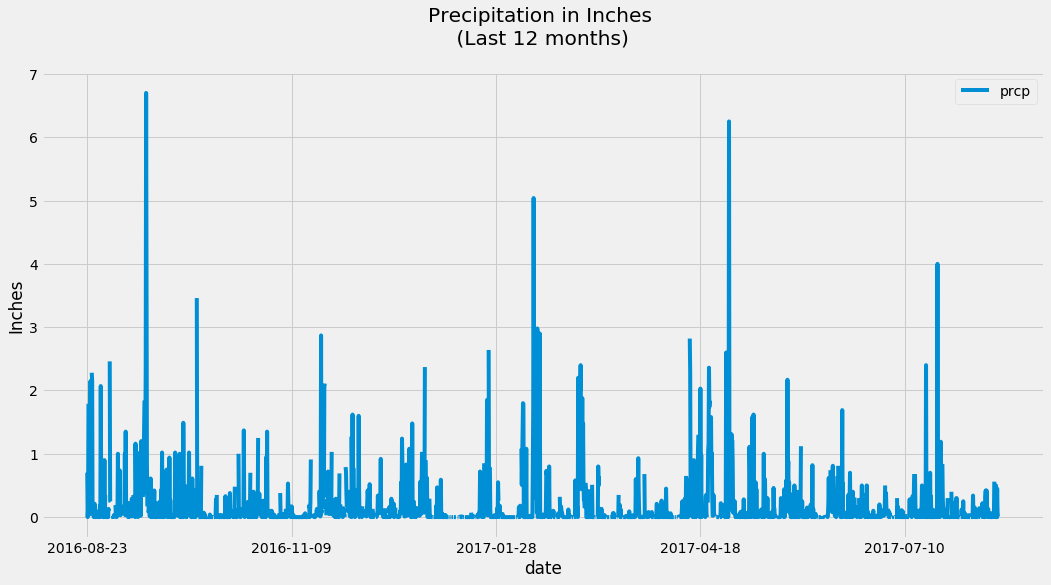

In [24]:
# Use Pandas Plotting with Matplotlib to plot the data
plot = df2.plot(title="Precipitation in Inches \n (Last 12 months) \n ", figsize=(16,8))
plot.set_ylabel("Inches")

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df2.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()
station_count

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# the most active station is USC00519281
session.query(Measurement.station).group_by(Measurement.station).filter(Measurement.station == 'USC00519281').all()

[('USC00519281')]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# session.query(Measurement.station).filter(Measurement.station == 'USC00519281').all()

sel = [Measurement.station,
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

most_active_station = session.query(*sel).filter(Measurement.station == 'USC00519281').statement

most_active_df = pd.read_sql_query(most_active_station, session.bind)
most_active_df.rename(columns={"station": "Station", "min_1": "Lowest Temp", "max_1": "Highest Temp", "avg_1": "Avg Temp"}, inplace=True)
most_active_df

,Station,Lowest Temp,Highest Temp,Avg Temp
0,USC00519281,54.0,85.0,71.663781


Text(0, 0.5, 'Frequency')

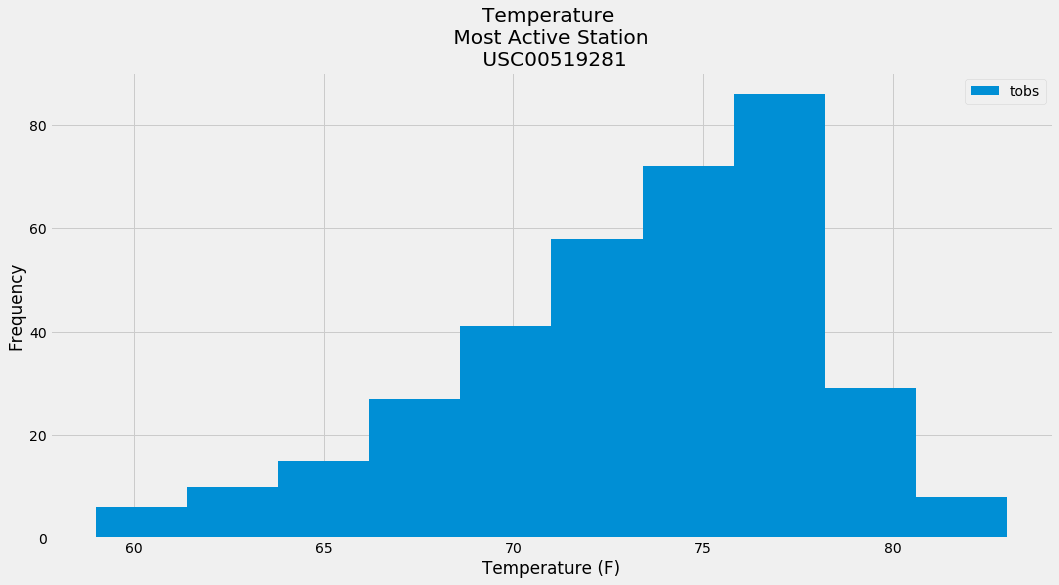

In [23]:
# Choose the station with the highest number of temperature observations.

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# session.query(Measurement.station).filter(Measurement.station == 'USC00519281').all()

last_12_months_most_active = session.query(Measurement.date, Measurement.tobs).\
                             filter(Measurement.date >= query_date).order_by(Measurement.date.desc()).\
                             filter(Measurement.station == 'USC00519281').statement  

active_station_df = pd.read_sql_query(last_12_months_most_active, session.bind)
active_station_df2 = active_station_df.set_index("date")

# Sort the dataframe by date
active_station_df2.sort_values(["date"], ascending=True, inplace=True)
active_station_df2

# Create histogram
temp_plot = active_station_df2.plot(kind='hist', title="Temperature \n Most Active Station \n USC00519281", figsize=(16,8))
temp_plot.set_xlabel("Temperature (F)")
temp_plot.set_ylabel("Frequency")

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
